In [ ]:
#%matplotlib qt
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import scipy
import pretty_midi as pm
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import librosa
import librosa.display
import math
import itertools
from IPython.display import Audio
import time

In [129]:
class Sonify:
  
  def read_data(self, path):
    """Read the data from the given csv file path."""
    if not path.endswith(".csv"): # If provided path is not a valid csv file
      print("Invalid file path. Must be .csv file.")
      raise FileNotFoundError()
    self.df = pd.read_csv(path) # Loads csv file
    print("Dataset loaded correctly:", path)

    # Constants used to add cumulative seconds values in function inside loop
    entries_per_day = 12*24 # 12 samples an hour (every 5 mins), 24 hours in a day
    seconds_per_day = 60*60*24

    # Constants used to create Kp comparison value
    self.density_max = np.max(self.df["proton_density"])
    self.speed_max = np.max(self.df["speed"])

    # for i, row in self.df.iterrows(): # Iterates through rows, replacing error data with the average of the previous value and the next valid (i.e., non-error) value
      # Data cleanup
      # self.__cleanup_column("proton_density", row, i, threshold=0)
      # self.__cleanup_column("speed", row, i, threshold=0)
      # self.__cleanup_column("ion_temp", row, i, threshold=0)
      # self.__cleanup_column("bz", row, i, threshold=-10)
      # self.__cleanup_column("phi_angle", row, i, threshold=0)

      # Adding column for seconds since start of dataset
      # self.__cumulative_seconds(i, entries_per_day, seconds_per_day)

      # Adds a column for our own synthetic variable and a column for the difference between that variable and the Kp index.
      # self.__kp_comparison(i, row) # Not working fully yet

    # print(np.min(self.df["bz"]))
    # print(np.min(self.df["speed"]))
    # print(np.min(self.df["phi_angle"]))

    # print(np.max(self.df["bz"]))
    # print(np.max(self.df["speed"]))
    # print(np.max(self.df["phi_angle"]))

    # # Just for testing...
    # plt.plot(self.df["cumulative_secs"], self.df["kp_index"])
    # plt.title("KP Index over time")
    # plt.show()

    # plt.plot(self.df["cumulative_secs"], self.df["kp_equiv"])
    # plt.title("KP Equiv over time")
    # plt.show()

    # plt.plot(self.df["cumulative_secs"], self.df["kp_diff"])
    # plt.title("KP difference over time")
    # plt.show()

    # # print("Lowest density value:", np.min(self.df["proton_density"]))
    # # print("Lowest speed value:", np.min(self.df["speed"]))

    # print(self.df)
    # read the data into df
    # TODO check if path is ok, file format is ok, load data into dataframe
  
  def __cumulative_seconds(self, i, entries_per_day, seconds_per_day):
    """Adds a value for the amount of seconds passed since the start of the dataset for the current index."""
    current_day_in_dataset = math.floor(i / entries_per_day) # Gets the number of seconds to the start of the current day by rounding down
    self.df.at[i, "cumulative_secs"] = (current_day_in_dataset*seconds_per_day) + self.df.at[i, "sec_of_day"] # Adds the start of the current day and the seconds elapsed in current day.

  def __kp_comparison(self, i, row):
    """Generates a synthetic variable based on raw data which is compared to the kp index, the difference can
    be a variable we can map to something (maybe a filter parameter?)"""
    density_scaled = self.df.at[i, "proton_density"]/self.density_max # The density of the current entry scaled 0-1
    speed_scaled = self.df.at[i, "speed"]/self.speed_max # The speed of the current entry scaled 0-1
    phi_angle = self.df.at[i, "phi_angle"]

    if i == 0: # Edge case for the first index
      local_start_index = 0
      local_end_index = 2
    elif i == len(self.df.index)-1: # Edge case for the last index
      local_start_index = len(self.df.index) - 3
      local_end_index = len(self.df.index) - 1
    else: # All other indices
      local_start_index = i - 1
      local_end_index = i + 1

    local_phi_values = pd.Series.to_numpy(self.df.loc[local_start_index:local_end_index, "phi_angle"])
    local_time_values = pd.Series.to_numpy(self.df.loc[local_start_index:local_end_index, "cumulative_secs"])

    kp_equiv = density_scaled + speed_scaled * 9
    self.df.at[i, "kp_equiv"] = kp_equiv
    self.df.at[i, "kp_diff"] = row["kp_index"] - kp_equiv

  def __cleanup_column(self, column_title, row, i, threshold=0):
    """Cleans up the data by finding erroneous data, then setting it to the average of the previous cell and the next non-error cell in the specified column."""
    if row[column_title] < threshold: # If data is below threshold i.e., is an error
      next_valid_value = self.__find_next_non_error_cell(i, column_title, threshold) # Find the next non-error cell in the column
      self.df.at[i, column_title] = round((self.df.at[i-1, column_title] + next_valid_value)*0.5, 1) # Sets the current cell to the average of the previous cell and the next non-error one

  def __find_next_non_error_cell(self, i, column_title, threshold):
    """Finds the next value in a column above a given threshold using recursion."""
    next_value = self.df.at[i+1, column_title]
    if next_value > threshold: # If the next cell is above the threshold i.e., not an error, return the next cell
      return next_value
    else: # If the next cell is also an error, run the function again to try the next cell down
      return self.__find_next_non_error_cell(i+1, column_title, threshold)

  def read_midi(self, path):
    """Read the midifile into a dataframe."""
    
    midi_data = pm.PrettyMIDI(path)
    if not path.endswith(".mid"):
      print("Invalid file path. Must be .mid file.")
      raise FileNotFoundError()
    else: print('MIDI file loaded successfully:', path)

    segments = (np.array(pm.PrettyMIDI.get_beats(midi_data,start_time=0.0)))
    self.midi_grain_start = np.linspace(0, segments[-1], len(segments)*8)

    self.midi_grain_len = int(self.midi_grain_start[1] * self.sr)

  def read_audio(self, path):
    self.sr = 48000
    self.song = librosa.load(path, sr=self.sr)[0]
    print("Audio loaded correctly:", path)

  def midi_grains_dataframe(self):
    self.midi_grains_data = pd.DataFrame() # Data frame for grains segmented based on previously segmented MIDI file 1/32 notes

    for i, row in self.df.iterrows():
      self.midi_grains_data.at[i, "grain_id"] = i # Adds grain ID to dataframe
      
      grain_start = int(self.midi_grain_start[i] * self.sr) # Find starts sample for MIDI segmented grains
      self.midi_grains_data.at[i, "grain_start"] = grain_start # Adds start sample to data frame

      feature_values = self.__extract_features_from_grain(grain_start, self.midi_grain_len) # Extracts features, returns as list

      # Add features to dataframe
      self.midi_grains_data.at[i, "spec_band"] = feature_values[0]
      self.midi_grains_data.at[i, "rms"] = feature_values[1]
      self.midi_grains_data.at[i, "mfcc"] = feature_values[2]

    # print(self.midi_grains_data)

  def dp_grains_dataframe(self):
    """Creates the dataframe containing all datapoint grain ID's, start points and feature extraction values"""
    self.dp_grains_data = pd.DataFrame() # Data frame for grains segmented based on number of data points

    song_len_samp = self.song.size # Length of current song in samples
    self.total_grains_in_song = len(self.df.index) # Number of grains in song (just the length of the dataset)
    self.dp_grain_len = math.floor(song_len_samp / self.total_grains_in_song) # The length of each grain in samples

    for i, row in self.df.iterrows(): # Creates one grain for each row of dataframe

      self.dp_grains_data.at[i, "grain_id"] = i # Adds grain ID to dataframe

      grain_start = i*self.dp_grain_len # The start point of the current grain
      self.dp_grains_data.at[i, "grain_start"] = grain_start # Adding grain start sample index to dataframe
      
      feature_values = self.__extract_features_from_grain(grain_start, self.dp_grain_len) # Extracting features, return as list

      # Add features to dataframe
      self.dp_grains_data.at[i, "spec_band"] = feature_values[0]
      self.dp_grains_data.at[i, "rms"] = feature_values[1]
      self.dp_grains_data.at[i, "mfcc"] = feature_values[2]

    #print(self.dp_grains_data)

  def __extract_features_from_grain(self, grain_start, grain_len):
    
    grain_start = int(grain_start)
    grain_len = int(grain_len)
    
    grain = self.song[grain_start:grain_start+grain_len] # Selecting grain data based on start and end points

    # Spectral Bandwidth
    spec_band = librosa.feature.spectral_bandwidth(y=grain, sr=self.sr, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)
    
    # Root Mean Square
    rms = librosa.feature.rms(y=grain, frame_length=grain_len, hop_length=grain_len)
    
    # Mel Frequency Cepstrum Coefficients
    mfcc_coeffs = librosa.feature.mfcc(y=grain, sr=self.sr, n_mels=13, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)
    mfcc = math.sqrt(np.max(mfcc_coeffs))

    return [spec_band, rms, mfcc]

  def __map_feature_iterator(self, feature_list, datapoints_list, grains_dataframe, grains_type="dp"):    
    """"Maps the provided list of features to the provided list of datapoints in the dataset via assigning grain IDs"""
    # Loops through features provided in feature_list parameter
    
    mapping_start_time = time.time()
    
    for i, feature in enumerate(feature_list):

      # MIDI grains data sorted by current feature
      feature_sorted = grains_dataframe[["grain_id",feature]].sort_values(by=feature, axis='index', kind="mergesort", ignore_index=True)
      # Dataset dataset by current mapped value in datapoints_list
      self.df.sort_values(by=datapoints_list[i], axis="index", kind="mergesort", ignore_index=True, inplace=True)

      grain_id_column_title = grains_type + "_" + feature + "_grain_id" # Assembling new grain id column title for self.df
      feature_sorted.columns = [grain_id_column_title, feature] # Renaming columns in feature_sorted based on new titles

      # Adds the new grain ID column to the dataset self.df
      self.df = pd.concat([self.df, feature_sorted[grain_id_column_title]], axis="columns")

      # Re-sorts sorted self.df dataset
      self.df.sort_values(by="cumulative_secs", axis="index", kind="mergesort", ignore_index=True, inplace=True)

    # Determines time to map features for the current grain type and prints the result
    mapping_exec_time = time.time() - mapping_start_time
    print("Mapping ", grains_type, "grains complete in", round(mapping_exec_time, 3), "secs")
  
  def map_features(self):
    """Adds grain ID columns for both grain types to dataframe by calling __map_feature_iterator method"""
    feature_list = ["spec_band", "rms", "mfcc"] # Features to be mapped
    datapoints_list = ["proton_density", "bz", "ion_temp"] # Datapoints to be mapped
    
    # For datapoint grains
    grains_type = "dp"
    self.__map_feature_iterator(feature_list, datapoints_list, self.dp_grains_data, grains_type)

    # For MIDI grains
    grains_type = "midi"
    self.__map_feature_iterator(feature_list, datapoints_list, self.midi_grains_data, grains_type)

  def __sum_grains(self, list_of_grains):
    """Adds together the individual grains for each datapoint into the full grain for that datapoint"""
    # how do we want to compound the grains?
    # just sums them for now
    return np.sum(list_of_grains, axis=0)
    
  def scale_features(self):
    """Scale the data fields from self.df dataset to required ranges as audio processing parameters"""
    
    print('Scaling...', end='\r')
    
    # scale bz [0, 5000]
    bz = self.df['bz'].copy()
    bz = bz/np.max(bz)
    self.df['bz_scaled'] = bz
    
    # scale speed [1, 2]
    # we can also do [0, 2] if we want to have also a slow down feature
    speed = self.df['speed'].copy()
    speed -= speed.min()
    speed /= speed.max()
    speed += 1
    self.df['speed_scaled'] = speed
    
    # scale phi
    # no need to scale phi as we're
    # using only the direction (??)
    
    print('Scaling complete.')
    
  def __apply_bz(self, data, i):
    """Apply low pass / high pass based on bz"""
    # bz <  0 -> lowpass
    # bz >= 0 -> highpass
    # abs(bz) as cut-off freq.
    bz = self.df.iloc[i]['bz_scaled']
    
    normal_cutoff = (abs(bz)*0.5) + 0.01 # bz as cutoff
    order = 5
    b, a = scipy.signal.butter(order, normal_cutoff, btype=('low' if bz > 0 else 'high'),
                               analog=False) # bz sign determine lp|hp
    return scipy.signal.filtfilt(b, a, data)
    
  def __apply_speed(self, data, i, grain_len):
    """Change playback speed based on speed"""
    # fill up the gap by looping if needed ??
    speed = self.df.iloc[i]['speed_scaled']
    data = librosa.effects.time_stretch(data, rate=speed)
    data = np.append(data, data) # duplicate data, append one to other (cannot be more then twice as max speed value is 2)
    data = data[:grain_len] # trim
    
    return data

  def __apply_phi(self, data, i):
    """Change playback direction based on phi angle"""
    # phi <  0 -> (<<)
    # phi >= 0 -> (>>)
    phi = self.df.iloc[i]['phi_angle']
    
    return np.flip(data) if phi < 0 else data

  def __simple_envelope(self, data, grain_len):
    """Apply a simple envelope (50-sample-long fade on each end)"""
    a = np.arange(0,1,0.02) # Ramp up of the envelope
    len_a = len(a) # The length of the ramp
    flat = np.ones((grain_len-2*len_a)) # Flat middle section of envelope
    rev_a = np.flip(a) # Creating ramp down of envelope
    env = np.append(a,flat) # Adding ramp up and flat
    env = np.append(env,rev_a) # Adding together all the pieces

    return data * env
    
  def __compound_grains(self, grains_type='dp'):
    """Finds, sums, processes and appends all relevant grains from the dataset"""
    # iterating through rows of the solar wind data;
    # 1. compund three grains (use compound_function)
    # 2. apply mappings (bz -> lp|hp filter, speed -> time stretch, phi angle -> playback direction)
    # 3. attach together
    # Grains_type is string, determines whether to use midi or non-midi segmentation
    
    synth_start_time = time.time()
    
    if grains_type == 'dp':
        cols = ['dp_spec_band_grain_id', 'dp_rms_grain_id', 'dp_mfcc_grain_id']
        grains_dataframe = self.dp_grains_data
        grain_len = self.dp_grain_len
    elif grains_type == 'midi':
        cols = ['midi_spec_band_grain_id', 'midi_rms_grain_id', 'midi_mfcc_grain_id']
        grains_dataframe = self.midi_grains_data
        grain_len = self.midi_grain_len
    else:
        # raise an error ??
        pass

    grains_attached = [] # Initialises main return list containing all audio
    for i, row in self.df.iterrows(): # Iterating through rows of the dataset
      list_grains = [] # Resets list containing the data from the song to be summed to make compound grain
      for c in cols: # Loops through columns to pull grain audio samples
        grain_start = grains_dataframe[grains_dataframe['grain_id'] == row[c]]['grain_start'].values[0] # Gets grain based on grain ID in current column
        grain_end = grain_start + grain_len
        grain = self.song[int(grain_start):int(grain_end)]
        list_grains.append(grain)
      compound_grain = self.__sum_grains(list_grains)
        
      # print(i, '/', self.total_grains_in_song, ' merging grains...', end='\r')
      
      # On each compound grain, apply mappings
      compound_grain = self.__apply_bz(compound_grain, i)
      compound_grain = self.__apply_speed(compound_grain, i, grain_len)
      compound_grain = self.__apply_phi(compound_grain, i)
      
      # Simple envelope to smooth start and end
      compound_grain = self.__simple_envelope(compound_grain, grain_len)
      
      # Append to main output audio array
      grains_attached = np.append(grains_attached, compound_grain)
    
    synth_exec_time = time.time() - synth_start_time
    print("Completed assembly of", grains_type, "grains in", round(synth_exec_time, 3), "secs")

    return grains_attached

  def synthesise_both(self):
    self.dp_synth = self.__normalise(self.__compound_grains("dp"))
    self.midi_synth = self.__normalise(self.__compound_grains("midi"))

    return (self.dp_synth, self.midi_synth)

  def __normalise(self, audio):
    audio_max = np.max(np.abs(audio))
    norm_audio = audio*1/audio_max
    return norm_audio

  def __apply_reverb(self, grains_type="dp"):
    """Applies convolution reverb to sections of 36 grains"""
    
    rev_start_time = time.time()
    
    if grains_type == "dp":
      synth = self.dp_synth
      grain_len = self.dp_grain_len
    elif grains_type == "midi":
      synth = self.midi_synth
      grain_len = self.midi_grain_len
    else:
      # raise error
      pass
    
    output_reverb = np.zeros(synth.size)
    kp_section_no_of_datapoints = 36 # Number of datapoints in a Kp section
    kp_section_len = kp_section_no_of_datapoints*grain_len # Length of a Kp section in samples

    ir = librosa.load("./ir/ir_sydney_cathedral.wav", sr=self.sr, mono=True)[0] # Loading the IR
    ir = self.__normalise(ir)
    ir_padded = np.pad(ir, (0, kp_section_len - ir.size)) # Padding the IR to the same size as the section

    for i in range(0, len(self.df.index), kp_section_no_of_datapoints): # Loop for number of sections
      kp_section_start = i*grain_len # Start point in samples of current section
      kp_section = synth[kp_section_start:kp_section_start + kp_section_len] # Gets the actual section data

      if kp_section.size < ir_padded.size: # Edge case for final section, as padded IR array may be longer than remaining data
        np.pad(kp_section, (0, ir_padded.size - kp_section.size)) # Pads final section to length of padded IR

      ir_scale_factor = self.df.at[i, "kp_index"] / 9
      dry_scale_factor = 1 - ir_scale_factor
      ir_padded_scaled = ir_padded * ir_scale_factor # Scaling the IR based on Kp index

      Kp_Section = scipy.fft.fft(kp_section) # FFT of the kp_section
      Ir_Padded_Scaled = scipy.fft.fft(ir_padded_scaled) # FFT of the padded scaled IR

      Kp_Section_Reverb = Kp_Section * Ir_Padded_Scaled # Frequency domain multiplication

      kp_section_reverb = np.real(scipy.fft.ifft(Kp_Section_Reverb)) # Returns the real section in the time domain

      kp_section_mix = kp_section_reverb + (dry_scale_factor*kp_section) # Adding some of the dry signal back in for makeup gain

      for sample_index, sample in enumerate(kp_section_mix): # Loops through mixed section
        output_index = i * grain_len + sample_index # Corresponding index in output is the previous number of sections plus the current sample number
        output_reverb[output_index] = sample # Adding mixed sample to output

    output_reverb = self.__normalise(output_reverb)

    plt.plot(output_reverb)
    plt.show()

    rev_exec_time = time.time() - rev_start_time
    print("Applied reverb to", grains_type, "grains in", round(rev_exec_time, 3), "secs")

    return output_reverb

  def reverb_both(self):
    dp_synth_reverb = self.__apply_reverb("dp")
    midi_synth_reverb = self.__apply_reverb("midi")

    return (dp_synth_reverb, midi_synth_reverb)



  def animate_graph(self):
    """Animation function for our dataset over 2016 datapoints. Saves the video in your directory once the cell finished running."""

    self.df_anim = self.df.copy()
    
    # scaling data to a range of -1 to 1 for presentation
    colnames = list(self.df_anim.columns)
    colnames = colnames[2:]
  
    for column in colnames :
      if column != 'bt':
        self.df_anim[column] = self.df_anim[column] / np.max(self.df_anim[column])
    
    
    # creating empty lists for writing in values by animate function
    x = []
    proton_density = []
    ion_temp = []
    speed = []
    bz = []
    kp_index = []

    # counter variable for indexing
    iterator = itertools.takewhile(lambda x: x < 2016, itertools.count(1))
    
    #figure and axes
    fig = plt.figure(figsize=(8, 8), facecolor='black')
    ax = plt.subplot(frameon=False) 
    
    
   
    def animate(i):
        # animation function which is getting called by FuncAnimation
    
        #writing from the dataset to lists
        x.append(next(iterator))
        
        proton_density.append(self.df_anim['proton_density'].iat[next(iterator)])
        ion_temp.append((self.df_anim['ion_temp'].iat[next(iterator)])+0.5)
        speed.append(((self.df_anim['speed'].iat[next(iterator)])+0.5))
        bz.append(self.df_anim['bz'].iat[next(iterator)]+1.5)
        kp_index.append((self.df_anim['kp_index'].iat[next(iterator)])+1)

        #plotting data 
        plt.cla()

        ax.set_yticks(np.arange(0,2.5,0.5),['Proton Density','Ion Temperature','Speed','BZ', 'KP Index'])
        ax.get_yticklabels()[0].set_color('#00CF52')
        ax.get_yticklabels()[1].set_color('#032E3E')
        ax.get_yticklabels()[2].set_color('#19646A')
        ax.get_yticklabels()[3].set_color('#00C690')
        ax.get_yticklabels()[4].set_color('#88F0F1')
        
        
        plt.plot(x,proton_density, c='#00CF52' )
        plt.plot(x,ion_temp, c='#032E3E')
        plt.plot(x,speed, c='#19646A')
        plt.plot(x,bz, c='#00C690')
        plt.plot(x,kp_index, c='#88F0F1')
       
        plt.tight_layout()

    animation = anim.FuncAnimation(plt.gcf(), animate, interval=109)
   
    animation.save("data_animated.mp4")
    


In [130]:
sonify = Sonify()
sonify.read_data("./output_jack.csv") # solar_wind_data_2003-10-27 - 2003-11-02_ACTUAL.csv")

#sonify.read_audio("./corpus/02_Dido White Flag.wav")
#sonify.read_midi("./corpus/02_Dido White Flag_adjusted_2.mid")
#sonify.midi_grains_dataframe()
#sonify.dp_grains_dataframe()
#sonify.map_features()
#
## do necessary scaling inside a function
#sonify.scale_features()

# compound grains and apply mapping
#synth_outputs = sonify.synthesise_both()
#
#display(Audio(synth_outputs[0], rate=sonify.sr))
#plt.plot(synth_outputs[0])
#plt.show()
#
#display(Audio(synth_outputs[1], rate=sonify.sr))
#plt.plot(synth_outputs[1])
#plt.show()
#
## apply the reverb
#outputs_reverb = sonify.reverb_both()
#
#display(Audio(outputs_reverb[0], rate=sonify.sr))
#display(Audio(outputs_reverb[1], rate=sonify.sr))
#

Dataset loaded correctly: ./output_jack.csv


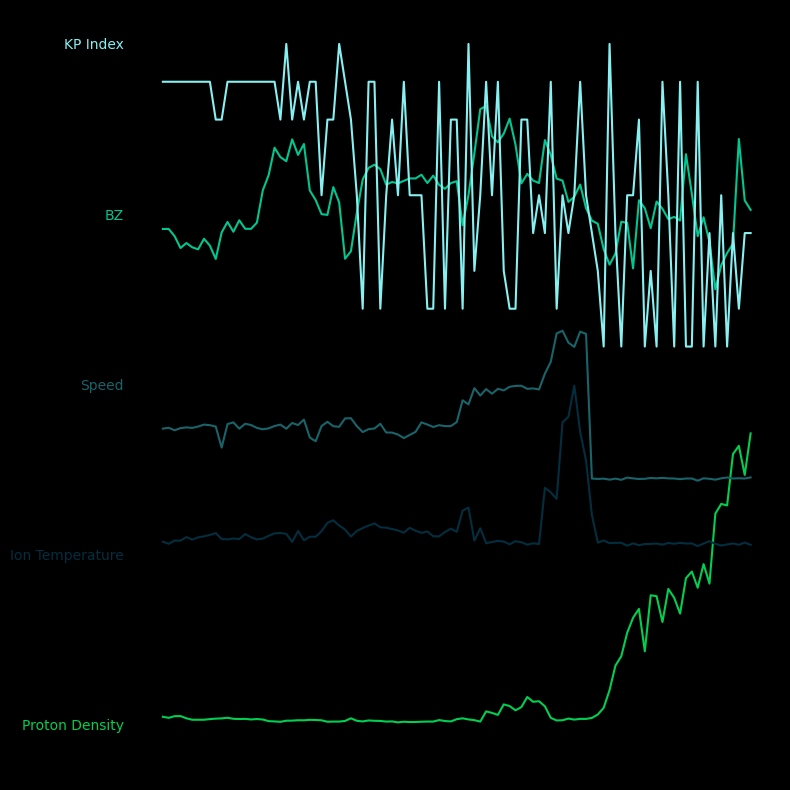

In [131]:
# test run animation

sonify.animate_graph()




      Unnamed: 0  cumulative_secs  proton_density   speed  ion_temp    bz  \
0              0                0            2.40  475.40   87800.0 -1.90   
1              1              300            2.24  475.36   96000.0 -1.50   
2              2              600            2.02  466.64   85800.0 -1.84   
3              3              900            2.06  461.84  100340.0 -1.80   
4              4             1200            2.11  465.80  165140.0 -1.82   
...          ...              ...             ...     ...       ...   ...   
2011        2011           603300            3.86  280.68   91840.0 -0.40   
2012        2012           603600            4.28  280.78   91900.0 -0.30   
2013        2013           603900            3.40  273.32   76320.0 -3.58   
2014        2014           604200            3.72  278.02   75900.0 -2.80   
2015        2015           604500            2.63  276.12   74170.0 -2.84   

         bt  phi_angle  kp_index  
0     10.60     309.50         8  
1    

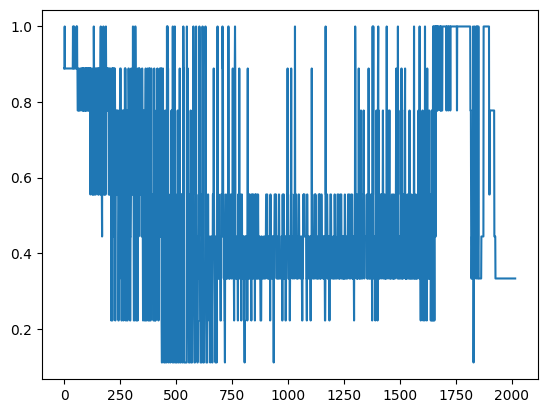

In [132]:

print(sonify.df)
plt.plot(sonify.df_anim['kp_index'])